In [1]:
!kaggle datasets download -d davi1990/empirical-data
!unzip empirical-data.zip
!rm empirical-data.zip

!kaggle datasets download -d davi1990/anatomical
!unzip anatomical.zip
!rm anatomical.zip

!kaggle datasets download -d davi1990/calculate-distance
!unzip calculate-distance.zip -d calculate-distance
!rm calculate-distance.zip

# @title Download Data

Dataset URL: https://www.kaggle.com/datasets/davi1990/empirical-data
License(s): MIT
 99% 668M/675M [00:11<00:00, 81.7MB/s]
100% 675M/675M [00:11<00:00, 61.4MB/s]
Archive:  empirical-data.zip
  inflating: all_eeg_evoked.npy      
  inflating: all_epo_seeg.pkl        
  inflating: dist_Schaefer_1000parcels_7net.pkl  
  inflating: example_epoched.fif     
Dataset URL: https://www.kaggle.com/datasets/davi1990/anatomical
License(s): MIT
 94% 259M/276M [00:02<00:00, 107MB/s]
100% 276M/276M [00:02<00:00, 115MB/s]
Archive:  anatomical.zip
  inflating: anatomical/example-bem  
  inflating: anatomical/example-src.fif  
  inflating: anatomical/example-trans.fif  
  inflating: anatomical/lh.Schaefer2018_200Parcels_7Networks_order.annot  
  inflating: anatomical/rh.Schaefer2018_200Parcels_7Networks_order.annot  
  inflating: anatomical/sub_dist.pickle  
Dataset URL: https://www.kaggle.com/datasets/davi1990/calculate-distance
License(s): MIT
 88% 153M/173M [00:02<00:00, 81.5MB/s]
100% 173M/173M [00

In [19]:
!git clone -b zheng_dev https://github.com/JohnWangDataAnalyst/whobpyt

# @title whobpyt Package

Cloning into 'whobpyt'...
remote: Enumerating objects: 3863, done.
remote: Counting objects: 100% (1567/1567), done.
remote: Compressing objects: 100% (559/559), done.
remote: Total 3863 (delta 1243), reused 1164 (delta 1008), pack-reused 2296
Receiving objects: 100% (3863/3863), 49.66 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (2145/2145), done.


In [3]:
import sys
!{sys.executable} -m pip install mne > /dev/null
!{sys.executable} -m pip install nilearn > /dev/null
!{sys.executable} -m pip install nibabel > /dev/null

# @title Install dependencies

In [20]:
path = 'whobpyt'

import os
import sys
sys.path.append(path)


import whobpyt
from whobpyt.datatypes import par, Recording
from whobpyt.data import dataloader
from whobpyt.models.JansenRit.jansen_rit_old import RNNJANSEN, ParamsJR
from whobpyt.optimization.custom_cost_JR import CostsJR
from whobpyt.run import Model_fitting

import numpy as np
import matplotlib.pyplot as plt # for plotting
#import pandas as pd
import scipy.io
import pandas as pd
import nibabel as nib
import nibabel
import mne
import pickle
import math
import requests
import seaborn as sns


import torch
from whobpyt.datatypes.parameter import par
from whobpyt.datatypes.AbstractLoss import AbstractLoss
from whobpyt.optimization.cost_TS import CostsTS
from whobpyt.functions.arg_type_check import method_arg_type_check



def euclidean_distance(coord1, coord2):
    x1, y1, z1 = coord1[0], coord1[1], coord1[2]
    x2, y2, z2 = coord2[0], coord2[1], coord2[2]
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)



# @title Importage

In [7]:
# Select the session number to use: Please do not change it as we are using subject-specific anatomy
ses2use = 10

# Load the precomputed EEG evoked response data from a file
all_eeg_evoked = np.load('all_eeg_evoked.npy')

# Read the epoch data from an MNE-formatted file
epo_eeg = mne.read_epochs('example_epoched.fif', verbose=False)

# Compute the average evoked response from the epochs
evoked = epo_eeg.average()

# Replace the data of the averaged evoked response with data from the selected session
evoked.data = all_eeg_evoked[ses2use]

# Load additional data from pickle files
with open('all_epo_seeg.pkl', 'rb') as handle:
    all_epo_seeg = pickle.load(handle)

with open('dist_Schaefer_1000parcels_7net.pkl', 'rb') as handle:
    dist_Schaefer_1000parcels_7net = pickle.load(handle)

# Extract the stimulation region data from the loaded pickle file
stim_region = dist_Schaefer_1000parcels_7net['stim_region']

# Load Schaefer 200-parcel atlas data from a URL
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)

# Extract coordinates and ROI labels from the atlas data
coords_200 = np.array([atlas['R'], atlas['A'], atlas['S']]).T
label = atlas['ROI Name']

# Remove network names from the ROI labels for clarity
label_stripped_200 = []

for xx in range(len(label)):
    label_stripped_200.append(label[xx].replace('7Networks_', ''))

# Load Schaefer 1000-parcel atlas data from a URL
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)

# Extract coordinates and ROI labels from the atlas data
coords_1000 = np.array([atlas['R'], atlas['A'], atlas['S']]).T
ROI_Name = atlas['ROI Name']

# Remove network names from the ROI labels for clarity
label_stripped_1000 = []

for xx in range(len(ROI_Name)):
    label_stripped_1000.append(ROI_Name[xx].replace('7Networks_', ''))



<ipython-input-7-fd07d197b7ca>:8: RuntimeWarning: This filename (example_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo_eeg = mne.read_epochs('example_epoched.fif', verbose=False)


In [8]:
# Find the index of the stimulation region in the list of stripped ROI labels (1000 parcels)
stim_idx = label_stripped_1000.index(stim_region[ses2use])

# Use the index to get the coordinates of the stimulation region from the 1000-parcel atlas
stim_coords = coords_1000[stim_idx]

# Extract the network name from the stimulation region label
# The network name is the part after the underscore in the stimulation region label
stim_net = stim_region[ses2use].split('_')[1]


In [9]:
# Initialize an empty list to store distances
distances = []

# Iterate over each coordinate in the 200-parcel atlas
for xx in range(coords_200.shape[0]):
    # Compute the Euclidean distance between the current coordinate and the stimulation coordinates
    # Append the computed distance to the distances list
    distances.append(euclidean_distance(coords_200[xx], stim_coords))

# Convert the list of distances to a NumPy array for easier manipulation
distances = np.array(distances)


In [10]:
# Iterate over the indices of the distances array, sorted in ascending order
for idx, item in enumerate(np.argsort(distances)):
    # Check if the network name of the stimulation region is present in the label of the current parcel
    if stim_net in label_stripped_200[item]:
        # If the condition is met, assign the index of the current parcel to `parcel2inject`
        parcel2inject = item
        # Exit the loop since the desired parcel has been found
        break


In [11]:
# Extract the absolute values of the EEG data for the specified session
abs_value = np.abs(all_epo_seeg[list(all_epo_seeg.keys())[ses2use]])

# Normalize each time series by subtracting its mean
for xx in range(abs_value.shape[0]):
    abs_value[xx, :] = abs_value[xx, :] - np.mean(abs_value[xx, :])

# Take the absolute value of the normalized data
abs_value = np.abs(abs_value)

# Find the starting and ending points around the maximum value in the data
# Get the index of the maximum value along the time axis
starting_point = np.where(abs_value == abs_value.max())[1][0] - 10
ending_point = np.where(abs_value == abs_value.max())[1][0] + 10

# Compute the maximum, mean, and standard deviation of the data within the range around the maximum
max_value = np.max(abs_value[:, starting_point:ending_point])
mean = np.mean(abs_value[:, starting_point:ending_point])
std = np.std(abs_value[:, starting_point:ending_point])

# Define a threshold as mean + 4 times the standard deviation
thr = mean + (4 * std)

# Count the number of unique regions affected by the threshold
number_of_region_affected = np.unique(np.where(abs_value > thr)[0]).shape[0]


In [12]:
img = nib.load('calculate-distance/calculate_distance/example/mri/example_Schaefer2018_200Parcels_7Networks_rewritten.nii')

# Get the shape and affine matrix of the image
shape, affine = img.shape[:3], img.affine

# Create a meshgrid of voxel coordinates
coords = np.array(np.meshgrid(*(range(i) for i in shape), indexing='ij'))

# Rearrange the coordinates array to have the correct shape
coords = np.rollaxis(coords, 0, len(shape) + 1)

# Apply the affine transformation to get the coordinates in millimeters
mm_coords = nib.affines.apply_affine(affine, coords)

# Initialize an array to store the coordinates of the 200 parcels
sub_coords = np.zeros((3, 200))

# Loop over each parcel (1 to 200)
for xx in range(1, 201):
    # Find the voxel coordinates where the parcel value equals the current parcel number
    vox_x, vox_y, vox_z = np.where(img.get_fdata() == xx)

    # Calculate the mean coordinates in millimeters for the current parcel
    sub_coords[:, xx - 1] = np.mean(mm_coords[vox_x, vox_y, vox_z], axis=0)



# Initialize an empty list to store distances
distances = []

# Compute the Euclidean distance between each coordinate in the 200-parcel atlas and the coordinate of the parcel to inject
for xx in range(coords_200.shape[0]):
    distances.append(euclidean_distance(sub_coords[:,xx], sub_coords[:,parcel2inject]))

# Convert the list of distances to a NumPy array for further processing
distances = np.array(distances)

# Find the indices of the closest parcels to inject, based on the number of affected regions
inject_stimulus = np.argsort(distances)[:number_of_region_affected]

# Compute stimulus weights based on the distances
# Adjust distances to a scale of 0 to 1 and calculate the values for the stimulus weights
values = (np.max(distances[inject_stimulus] / 10) + 0.5) - (distances[inject_stimulus] / 10)

# Initialize an array for stimulus weights with zeros
stim_weights_thr = np.zeros((len(label)))

# Assign the computed values to the stimulus weights for the selected parcels
stim_weights_thr[inject_stimulus] = values


In [13]:
# File paths for transformation, source space, and BEM files
trans = 'anatomical/example-trans.fif'
src = 'anatomical/example-src.fif'
bem = 'anatomical/example-bem'

# Create a forward solution using the provided transformation, source space, and BEM files
# Only EEG is used here; MEG is disabled
fwd = mne.make_forward_solution(epo_eeg.info, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=2,
                                verbose=False)

# Extract the leadfield matrix from the forward solution
leadfield = fwd['sol']['data']

# Convert the forward solution to a fixed orientation with surface orientation
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
# Update the leadfield matrix to use the fixed orientation
leadfield = fwd_fixed['sol']['data']

# Read the source spaces from the source space file
src = mne.read_source_spaces(src, verbose=False)

# Extract vertex indices for each hemisphere from the forward solution
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]

# Read annotation files for left and right hemispheres
lh_vertices = nibabel.freesurfer.io.read_annot('anatomical/lh.Schaefer2018_200Parcels_7Networks_order.annot')[0]
rh_vertices = nibabel.freesurfer.io.read_annot('anatomical/rh.Schaefer2018_200Parcels_7Networks_order.annot')[0]

# Extract vertices corresponding to the parcels from the annotation files
# Add 100 to right hemisphere vertices to adjust for parcel numbering
lh_vertices_thr = lh_vertices[vertices[0]]
rh_vertices_thr = rh_vertices[vertices[1]] + 100

# Combine left and right hemisphere vertices into a single array
vertices_thr = np.concatenate([lh_vertices_thr, rh_vertices_thr])

# Initialize a new leadfield matrix with dimensions adjusted for the number of parcels
new_leadfield = np.zeros((leadfield.shape[0], np.unique(vertices_thr).shape[0] - 1))

# Compute the average leadfield for parcels in the range 1-100
for parcel in range(1, 101):
    new_leadfield[:, parcel - 1] = np.mean(leadfield[:, np.where(vertices_thr == parcel)[0]], axis=1)

# Compute the average leadfield for parcels in the range 101-200
for parcel in range(101, 201):
    new_leadfield[:, parcel - 1] = np.mean(leadfield[:, np.where(vertices_thr == parcel)[0]], axis=1)




    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


In [14]:
# Load structural connectivity data from a CSV file
sc_file = 'https://raw.githubusercontent.com/GriffithsLab/PyTepFit/main/data/Schaefer2018_200Parcels_7Networks_count.csv'
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values

# Download distance data from Google Drive
dist_file = "https://drive.google.com/uc?export=download&id=1EzJNFckal6n4uXMY3h31Wtd9aqsCmgGc"
response = requests.get(dist_file)

# Save the downloaded distance data to a CSV file
with open('Schaefer2018_200Parcels_7Networks_distance.csv', 'wb') as f:
    f.write(response.content)

# Load the distance data from the saved CSV file
dist_df = pd.read_csv('Schaefer2018_200Parcels_7Networks_distance.csv', header=None, sep=' ')
dist = dist_df.values

# Apply log transformation and normalization to the structural connectivity matrix
sc = np.log1p(sc) / np.linalg.norm(np.log1p(sc))

# Initialize the stimulus weights for further processing
ki0 = stim_weights_thr[:, np.newaxis]

# Extract and normalize EEG data from the evoked response
eeg_data = evoked.data
eeg_data = eeg_data[:, 200:600].T / (np.abs(eeg_data)).max() * 2

# Define model parameters
node_size = sc.shape[0]
output_size = eeg_data.shape[1]
batch_size = 20
step_size = 0.0001
pop_size = 3
num_epochs = 150
tr = 0.001
state_size = 6
base_batch_num = 20
time_dim = 400
hidden_size = int(tr / step_size)
TPperWindow = batch_size

# Prepare the data structure for the model
data_mean = dataloader(eeg_data - eeg_data.mean(1)[:, np.newaxis], num_epochs, batch_size)

# Initialize the leadfield matrix for the model
lm = new_leadfield.copy() / 10

# Initialize random values for the leadfield matrix
lm_v = 0.01 * np.random.randn(output_size, 200)


In [21]:
params = ParamsJR(A = par(3.25), a= par(100,100, 2, True), B = par(22), b = par(50, 50, 1, True), \
              g=par(200), g_f=par(10), g_b=par(10), \
              c1 = par(135, 135, 1, True), c2 = par(135*0.8, 135*0.8, 1, True), \
              c3 = par(135*0.25, 135*0.25, 1, True), c4 = par(135*0.25, 135*0.25, 1, True),\
              std_in= par(np.log(1.1),np.log(1.1), 0.1, True, True), vmax= par(5), v0=par(6), r=par(0.56), \
                  y0=par(-2, -2, 0.3, True),\
              mu = par(1,1, 0.1, True), k = par(10,10, .2, True),\
                  Mr0 = par(0),\
                  Er0 = par(0), Ir0 = par(0),\
              cy0 = par(1,1,0.1,True), ki=par(ki0), \
              lm=par(lm, lm, .1 * np.ones((output_size, node_size))+lm_v, True))

model = RNNJANSEN(params, node_size=node_size, TRs_per_window=TPperWindow, step_size=step_size, output_size=output_size, tr=tr, sc=sc, lm=lm, dist=dist, use_fit_gains=True)

# %%
# create objective function
ObjFun = CostsJR(model)

# %%
# call model fit
F = Model_fitting(model, ObjFun)

# %%
# Model Training
# ---------------------------------------------------
#

u = np.zeros((node_size,hidden_size,time_dim, pop_size))
u[:,:,65:75,0]= 2000
F.train(u = u, empRec = data_mean, num_epochs = num_epochs, TPperWindow = TPperWindow,  warmupWindow=20)
# %%
# Model Evaluation (with 20 window for warmup)
# ---------------------------------------------------
#
F.evaluate(u = u, empRec = data_mean, TPperWindow = TPperWindow, base_window_num = 100)



Epoch:  0
torch.Size([200, 3, 2])
eeg epoch:  0 loss: 1.7125047326087952 Pseudo FC_cor:  0.2920101284974879 cos_sim:  0.10897767989401472
Epoch:  1
torch.Size([200, 3, 2])
eeg epoch:  1 loss: 0.8405361980199815 Pseudo FC_cor:  0.7838986293783298 cos_sim:  0.25420435855193235
Epoch:  2
torch.Size([200, 3, 2])
eeg epoch:  2 loss: 0.4635416530072689 Pseudo FC_cor:  0.7357938446203108 cos_sim:  0.40568788992621774
Epoch:  3
torch.Size([200, 3, 2])
eeg epoch:  3 loss: 0.40822123214602474 Pseudo FC_cor:  0.8820342241474984 cos_sim:  0.5716035310590836
Epoch:  4
torch.Size([200, 3, 2])
eeg epoch:  4 loss: 0.32811835408210754 Pseudo FC_cor:  0.7847688187458467 cos_sim:  0.7073836298475923
Epoch:  5
torch.Size([200, 3, 2])
eeg epoch:  5 loss: 0.34049646332859995 Pseudo FC_cor:  0.9130102265017126 cos_sim:  0.6714812047099861
Epoch:  6
torch.Size([200, 3, 2])
eeg epoch:  6 loss: 0.3174280859529972 Pseudo FC_cor:  0.8841109906706984 cos_sim:  0.7232295367038478
Epoch:  7
torch.Size([200, 3, 2])
e

No projector specified for this dataset. Please consider the method self.add_proj.


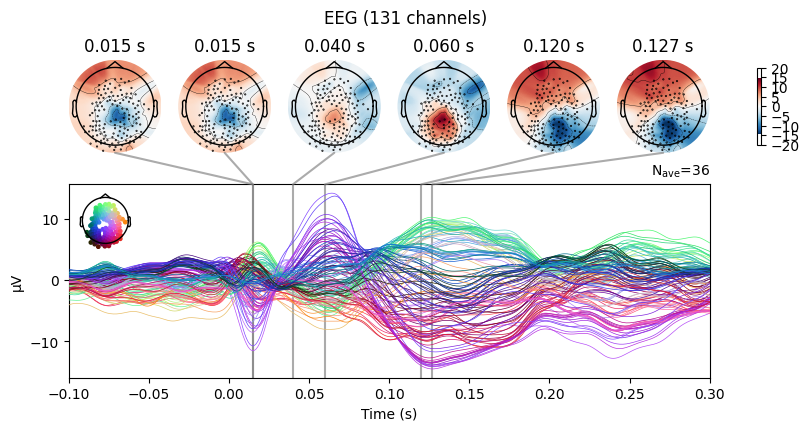

No projector specified for this dataset. Please consider the method self.add_proj.


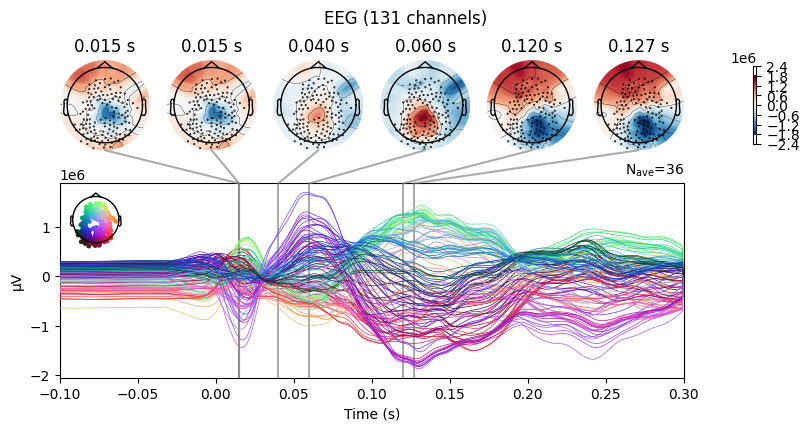

In [22]:
time_start = np.where(evoked.times==-0.1)[0][0]
time_end = np.where(evoked.times==0.3)[0][0]

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.015);
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.015, tmax=0.03);
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.03, tmax=0.04);
ch, peak_locs4 = evoked.get_peak(ch_type='eeg', tmin=0.04, tmax=0.06);
ch, peak_locs5 = evoked.get_peak(ch_type='eeg', tmin=0.08, tmax=0.12);
ch, peak_locs6 = evoked.get_peak(ch_type='eeg', tmin=0.12, tmax=0.2);

ts_args = dict(xlim=[-0.1,0.3]) #Time to plot

times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5, peak_locs6]

evoked_joint_st = evoked.plot_joint(ts_args=ts_args, times=times);


simulated_EEG_st = evoked.copy()

simulated_EEG_st.data[:,time_start:time_end] = F.trainingStats.outputs['eeg_testing']

simulated_joint_st = simulated_EEG_st.plot_joint(ts_args=ts_args, times=times)
